# Spectrum Analyzer Stability
---------------

A daylog was taken for 2 hours using the MCS spectrum analyzer software. It was saved in .mdr format to be replayed using the software and then converted to .csv to do my own analysis on.

In [51]:
filename = r"Z:\AOM Stability Data\190824_2nd_AOM.csv"

In [52]:
import pandas as pd

timestamps = pd.read_csv(filename, 
                 header=1, # Headers are in the 1st row
                 sep=';',  # Field separator
                 decimal='.',  # Decimal separator
                 thousands=',',  # Thousands separator
                 usecols=[0]) 

timestamps.head




<bound method NDFrame.head of                     Timestamp
0     2024-08-19T16:48:43.557
1     2024-08-19T16:48:43.616
2     2024-08-19T16:48:43.680
3     2024-08-19T16:48:43.794
4     2024-08-19T16:48:43.890
...                       ...
1651  2024-08-19T16:51:34.396
1652  2024-08-19T16:51:34.503
1653  2024-08-19T16:51:34.599
1654  2024-08-19T16:51:34.698
1655  2024-08-19T16:51:34.805

[1656 rows x 1 columns]>

In [53]:
MHz = pd.read_csv(filename, 
                 header=1, # Headers are in the 1st row
                 sep=';',  # Field separator
                 decimal='.',  # Decimal separator
                 thousands=',',  # Thousands separator
                 nrows=0) # just use the first row


MHz = MHz.loc[:, ~MHz.columns.isin(['Timestamp', 'Measure Unit'])].astype(float)

# MHz.iloc[0:,x] selects the xth value in the row , might have to change row with 2002 columns to array idk




In [54]:
data = pd.read_csv(filename, 
                 header=1, # Headers are in the 1st row
                 sep=';',  # Field separator
                 decimal='.',  # Decimal separator
                 thousands=',')  # Thousands separator


data = data.loc[:, ~data.columns.isin(['Timestamp', 'Measure Unit'])]

# for this one, the headers are the MHz values and all the other data in the dataframe is the dbm values to be plotted

# Print the column names to check for unexpected entries
print("Columns in data:")
print(data.columns)

# Identify columns that can't be converted to float
non_numeric_columns = [col for col in data.columns if not col.replace('.', '', 1).isdigit()]
print("Non-numeric columns:")
print(non_numeric_columns)


data_filtered = data.loc[:, ~data.columns.isin(non_numeric_columns)]
MHz = data_filtered.columns.astype(float)



Columns in data:
Index(['70000000', '70400000', '70800000', '71200000', '71600000', '72000000',
       '72400000', '72800000', '73200000', '73600000', '74000000', '74400000',
       '74800000', '75200000', '75600000', '76000000', '76400000', '76800000',
       '77200000', '77600000', '78000000', '78400000', '78800000', '79200000',
       '79600000', '80000000', '80400000', '80800000', '81200000', '81600000',
       '82000000', '82400000', '82800000', '83200000', '83600000', '84000000',
       '84400000', '84800000', '85200000', '85600000', '86000000', '86400000',
       '86800000', '87200000', '87600000', '88000000', '88400000', '88800000',
       '89200000', '89600000', '90000000', 'Unnamed: 53'],
      dtype='object')
Non-numeric columns:
['Unnamed: 53']


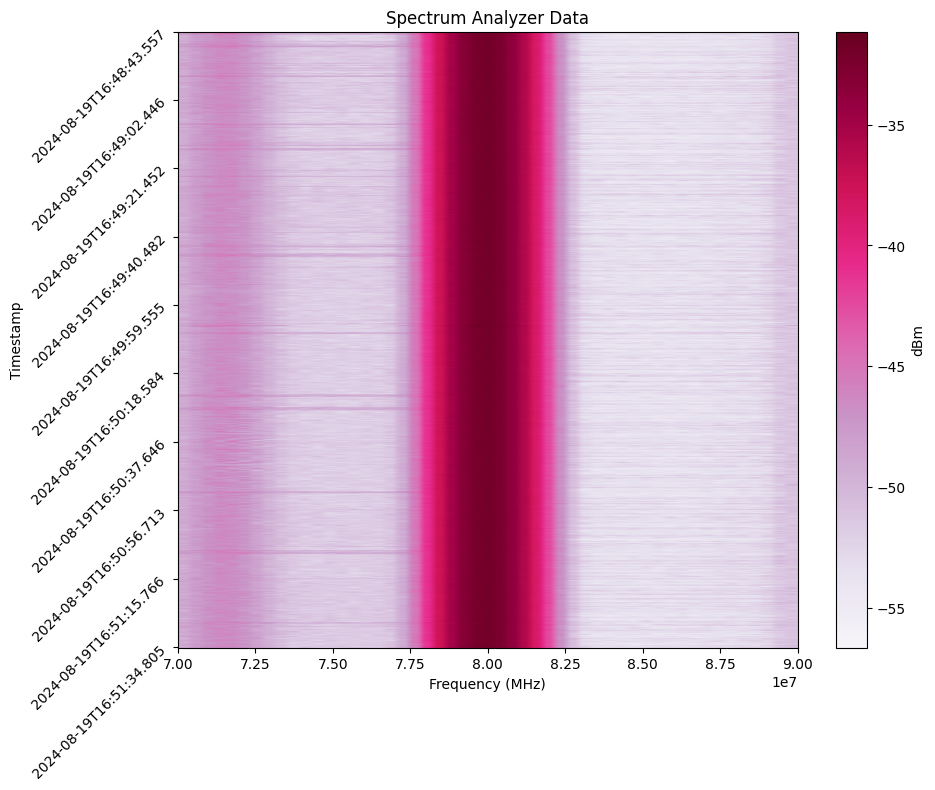

In [55]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

Z = data_filtered.values
#timestamps['Timestamp'] = pd.to_datetime(timestamps['Timestamp']).dt.strftime('%H:%M:%S')

plt.figure(figsize=(10, 8))
plt.imshow(Z, aspect='auto', cmap='PuRd', extent=[MHz.min(), MHz.max(), Z.shape[0], 0])
plt.colorbar(label='dBm')  # Show color scale
plt.xlabel('Frequency (MHz)')
plt.ylabel('Timestamp')
num_ticks = 10  # Number of y-ticks to display
y_ticks = np.linspace(0, Z.shape[0]-1, num_ticks, dtype=int)
y_labels = timestamps.iloc[y_ticks, 0].values
plt.yticks(y_ticks, y_labels, rotation=45)

plt.title('Spectrum Analyzer Data')
plt.show()

(1656,)
(1656,)


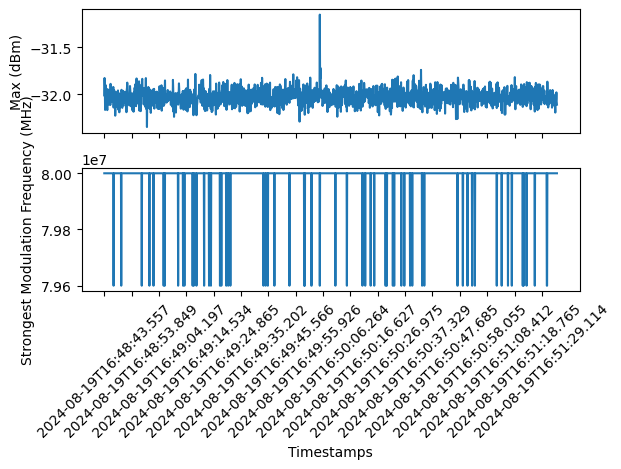

In [56]:
# now plot the maximum value (y axis) against timestamp (x axis)

def maxelement(arr):
    
    no_of_rows = len(arr)

    maxvals = []
    maxidxs = []
     
    for i in range(no_of_rows):
        maxvals.append(np.max(arr[i,:]))
        maxidxs.append(np.argmax(arr[i,:]))
         
    return maxidxs, maxvals # x = index, y = value. need to convert index to appropriate MHz value


x,y = maxelement(Z)

y = np.array(y)

ts = timestamps.values.flatten()
print(ts.shape)
print(y.shape)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(ts, y)
ax1.set_ylabel('Max (dBm)')

# Set x-ticks at regular intervals so its not super crowded!!
interval = 100  
ax1.set_xticks(ts[::interval])
ax1.set_xticklabels(ts[::interval], rotation=45)  

# also plot how the max MHz position varies over time

MaxMHz = MHz[x].values

ax2.plot(ts,MaxMHz)

ax2.set_xticks(ts[::interval])
ax2.set_xticklabels(ts[::interval], rotation=45)  

plt.xlabel('Timestamps')
plt.ylabel('Strongest Modulation Frequency (MHz)')
plt.tight_layout()  
plt.show()

# note: using np.argmax if there are multiple instances of the maximum will just return the first instance!
# It would be better to clean up the data and then fit a sharp peak to it to find the maximum





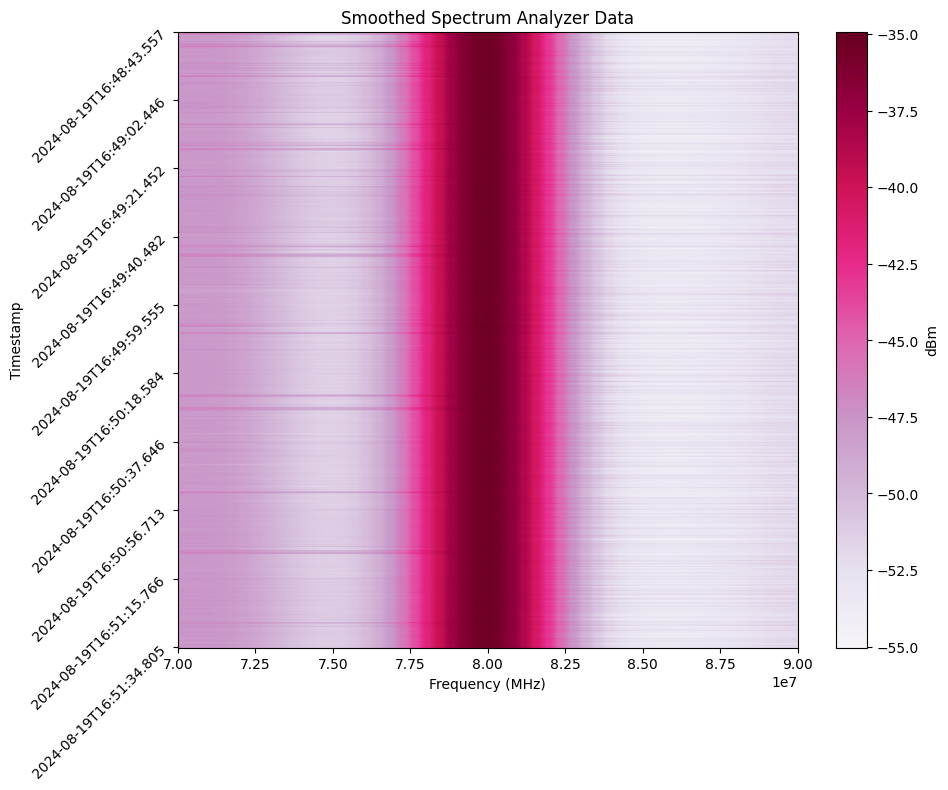

ValueError: cannot convert float NaN to integer

In [57]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

sig = 3
peak_threshold = -20

# filter each row of the noisy MHz data

# make a copy of Z, we will change each row to the smoothed data
Z_filt = Z.copy()
peak_locs = []
peak_vals = []
nan_locs = []


for i, row in enumerate(Z):
    # Smooth the data first then find the peaks
    row_filt = gaussian_filter1d(row, sigma=sig)
    
    try:
        peaks, _ = find_peaks(row_filt, height=peak_threshold)
    except Exception as e:
        print(f"Error finding peaks in row {i}: {e}")
        peaks = np.array([])
    
    Z_filt[i] = row_filt
    
    if peaks.size > 0:
        peak_locs.append(peaks[0])  # Add the first peak location to the array
        nan_locs.append(np.nan) # add nan to the nan_locs array to keep it the correct size for when we scatter plot it later
    else:
        peak_locs.append(np.nan)  # Add NaN if no peaks are found
        nan_locs.append(ts[i]) # record the row that now peaks are found, to be plotted with timestamps later
    
    peak_vals.append(np.max(row_filt))

# Ensure peak_locs are homogeneous and convert to a numpy array
peak_locs = np.array(peak_locs)
peak_vals = np.array(peak_vals)

peaks_MHz = []
for loc in peak_locs:
    if not np.isnan(loc) and 0 <= loc < len(MHz):
        peaks_MHz.append(MHz[int(loc)])
    else:
        peaks_MHz.append(np.nan)



plt.figure(figsize=(10, 8))
plt.imshow(Z_filt, aspect='auto', cmap='PuRd', extent=[MHz.min(), MHz.max(), Z_filt.shape[0], 0])
plt.colorbar(label='dBm')  # Show color scale
plt.xlabel('Frequency (MHz)')
plt.ylabel('Timestamp')
num_ticks = 10  # Number of y-ticks to display
y_ticks = np.linspace(0, Z_filt.shape[0]-1, num_ticks, dtype=int)
y_labels = timestamps.iloc[y_ticks, 0].values
plt.yticks(y_ticks, y_labels, rotation=45)

plt.title('Smoothed Spectrum Analyzer Data')
plt.show()


# plot filtered and unfiltered of one row side by side

row_index = 0
row_data = Z[row_index]
row_data_filt = Z_filt[row_index]
peak_loc = peak_locs[row_index]
peak_freq = MHz[int(peak_loc)]


plt.figure(figsize=(10, 6))
plt.plot(MHz, row_data, label='raw')
plt.plot(MHz, row_data_filt, label='filtered with $\sigma=${}'.format(sig))
plt.axvline(peak_freq, color='r', linestyle='dashed', label='peak @ {}MHz'.format(peak_freq.astype(float)))
plt.xlabel('Timestamp')
plt.ylabel('Amplitude (dBm)')
plt.title('Smoothing filter effect (Row {})'.format(row_index))
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

print(nan_locs)

# # find inhomogeneous elements!!
# def locate_inhomogeneous_elements(lst):
#     inhomogeneous_elements = []
    
#     for i, element in enumerate(lst):
#         if not isinstance(element, float):
#             inhomogeneous_elements.append((i, element, type(element)))
    
#     return len(inhomogeneous_elements), inhomogeneous_elements

# print(locate_inhomogeneous_elements(peaks_MHz))

# peaks_MHz = [float(x) if isinstance(x, (int, str)) else x for x in peaks_MHz]

# print(locate_inhomogeneous_elements(peaks_MHz))

# print(locate_inhomogeneous_elements(MHz))
# print(MHz.shape)
# print(peak_locs)

# if isinstance(peaks_MHz, list):
#     peaks_MHz = np.array([item for sublist in peaks_MHz for item in sublist])

# print(len(ts), len(peaks_MHz))

range of signal strength over 2hrs: 0.5898948373065593dbm
range of signal peak frequency over 2hrs: 0.0KHz


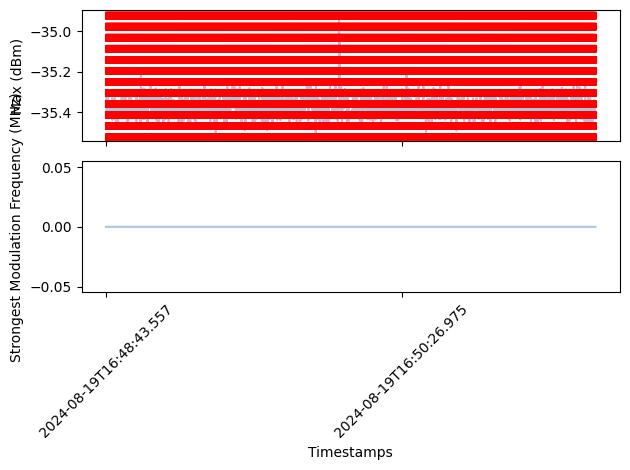

In [ ]:
# now make the same plot as above but for the smoothed data

def rolling_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def rolling_avg_std(data, window_size):
    # Calculate the rolling average
    data = np.array(data)
    rolling_avg = rolling_average(data, window_size)
    
    # Calculate the squared differences
    squared_diff = np.convolve(data**2, np.ones(window_size), 'valid') / window_size
    
    # Calculate the rolling standard deviation
    rolling_std = np.sqrt(squared_diff - rolling_avg**2)

    # pad the std dev and avg so they are the same size as the original data and can be plotted alongside it
    padding = np.full((window_size - 1,), np.nan)

    rolling_avg = np.concatenate((padding,rolling_avg))
    rolling_std = np.concatenate((padding,rolling_std))
    
    return rolling_avg, rolling_std


# dbm_avg, dbm_std = rolling_avg_std(peak_vals,20)

# upper = dbm_avg + dbm_std
# lower = dbm_avg - dbm_std

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(ts, peak_vals, alpha=0.4)
for p in nan_locs:
    ax1.axvline(p, color='r', linestyle='dashed')
# ax1.plot(ts,dbm_avg)
# ax1.plot(ts,upper, color='orange', linestyle='--')
# ax1.plot(ts,lower, color='orange', linestyle='--')
# ax1.fill_between(ts,lower,upper,color='orange' ,alpha=0.5)
ax1.set_ylabel('Max (dBm)')

# Set x-ticks at regular intervals so its not super crowded!!
interval = 1000
ax1.set_xticks(ts[::interval])
ax1.set_xticklabels(ts[::interval], rotation=45)  

# also plot how the max MHz position varies over time

# peaks_MHz = np.array(peaks_MHz)


# MHz_avg, MHz_std = rolling_avg_std(peaks_MHz,100)

# upper = MHz_avg + MHz_std
# lower = MHz_avg - MHz_std 

ax2.plot(ts, peaks_MHz, alpha=0.4)
# ax2.plot(ts,MHz_avg)
# ax2.plot(ts,upper, color='orange', linestyle='--')
# ax2.plot(ts,lower, color='orange', linestyle='--')
# ax2.fill_between(ts,lower,upper,color='orange' ,alpha=0.5)

ax2.set_xticks(ts[::interval])
ax2.set_xticklabels(ts[::interval], rotation=45)  


ax2.set_ylabel('Strongest Modulation Frequency (MHz)')


valsdif = np.nanmax(peak_vals)-np.nanmin(peak_vals)
print('range of signal strength over 2hrs: {}dbm'.format(valsdif))

MHzdif = (np.nanmax(peaks_MHz)-np.nanmin(peaks_MHz))/1000
print('range of signal peak frequency over 2hrs: {}KHz'.format(MHzdif))


plt.xlabel('Timestamps')

plt.tight_layout()
plt.show()


range of signal strength over 1.03 minutes: 0.28dbm
range of signal peak frequency: 0.00KHz
range of delta: 0.00KHz


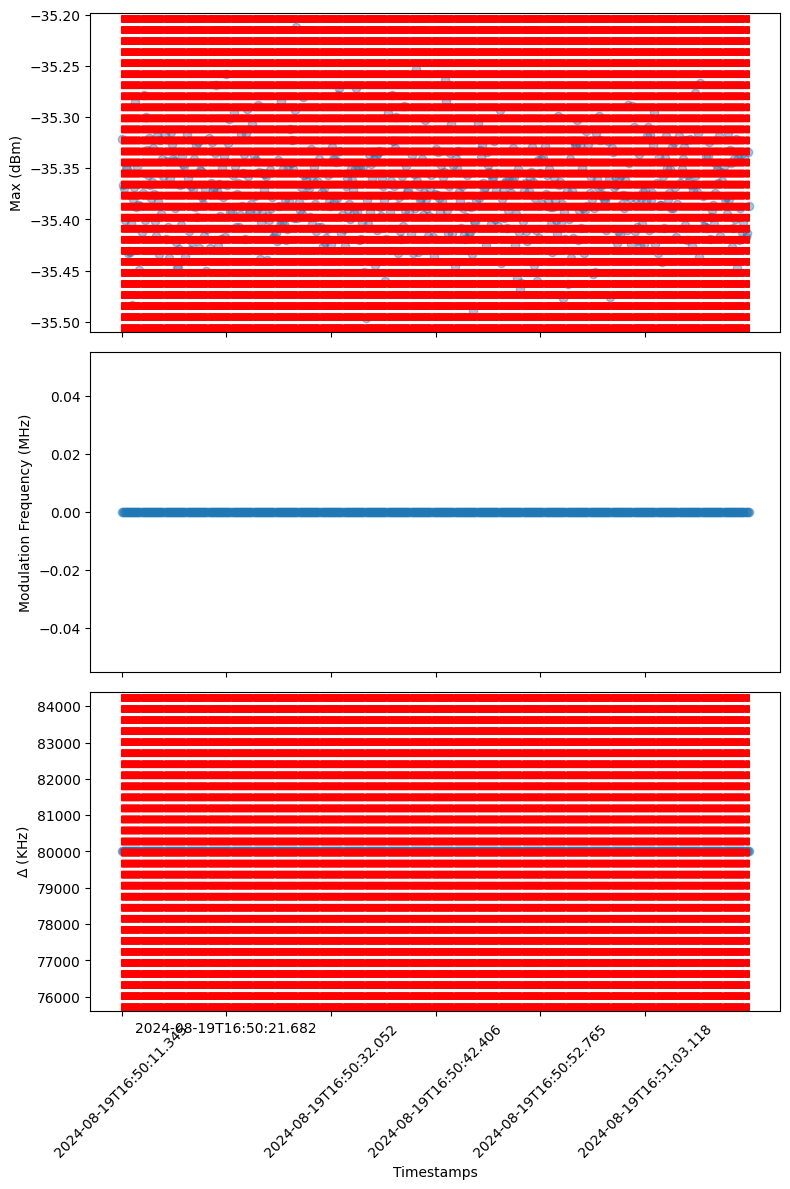

In [ ]:
# Now select many 1sec intervals in the dataset and calculate the average gradient by fitting a line, then average the absolute gradient (positive or negative
# doesn't matter) to interpolate the linear change in peak frequency per ms or microsecond. Bear in mind, the better way to do this would be to use a higher time resolution
# spectrum analyzer since the funny peak flattening moments only became visible at all when we decreased the sample time from 500ms to 5ms

# ts are the timestamps for the x axis
# peaks_MHz are the values of modulation frequency, where peaks_MHz[i] is the frequency at ts[i]



####################################################
# take a random number generator to generate r in the range 100 to len(ts) - 300 (we need 200 timesteps of 5ms to equate to 1sec) 
# and select the timesteps ts[r] to ts[r+200]
# this restricts the random sample area to just the middle of the data amd emsures we don't run off the edge

# check if peaks_MHz[r] = NaN, if so, take the modulation frequency at this position to be 0 as the frequency generator is not outputting anything

# plot delta (where delta = 80MHz - peaks_MHz) against time for one second

# fit a line to this data (we assume the gradient at this short time is linear)

# if the fit is clearly not appropriate, decrease the length of time and find that gradient instead

# calculate the change in KHz/microsecond via linear interpolation
#####################################################

import random as rd

timespan = 600 #(seconds or hours or whatever. depends on sampletime and stuff)

DC_modulation = 80e6 #(Hz)

r = rd.randint(100, len(ts)-100)

ts_sample = ts[r:r+timespan] 
MHz_sample = np.array(peaks_MHz[r:r+timespan])
vals_sample = peak_vals[r:r+timespan]
nan_sample = nan_locs[r:r+timespan]

MHz_sample_no_nans = np.nan_to_num(MHz_sample, nan=0) # subtracting nan from a float turns the result into a nan, there is no signal so set to 0


fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(8, 12))
###
ax1.scatter(ts_sample, vals_sample, alpha=0.4)
for p in nan_sample: # annotate the times where signal stopped
    ax1.axvline(p, color='r', linestyle='dashed')

ax1.set_ylabel('Max (dBm)')
###
ax2.scatter(ts_sample, MHz_sample, alpha=0.4) # plotted not including nans at all

ax2.set_xticks(ts_sample[::interval])
ax2.set_xticklabels(ts_sample[::interval], rotation=45)  

ax2.set_ylabel('Modulation Frequency (MHz)')
###
delta_khz = (DC_modulation-MHz_sample)/1000
ax3.scatter(ts_sample, delta_khz, alpha=0.4) # plotted without nans but annotating where no signal
for p in nan_sample: # annotate the times where signal stopped
    ax3.axvline(p, color='r', linestyle='dashed')

ax3.set_xticks(ts_sample[::interval])
ax3.set_xticklabels(ts_sample[::interval], rotation=45)  

ax3.set_ylabel('$\Delta$ (KHz)')
###
interval = 100
ax1.set_xticks(ts_sample[::interval])
ax1.set_xticklabels(ts_sample[::interval], rotation=45)  


ts_sample_datetime = [pd.to_datetime(timestamp) for timestamp in ts_sample]
timediff = (ts_sample_datetime[-1] - ts_sample_datetime[0]).total_seconds() / 60
valsdif = np.nanmax(vals_sample)-np.nanmin(vals_sample)
print('range of signal strength over {:.2f} minutes: {:.2f}dbm'.format(timediff,valsdif))

MHzdif = (np.nanmax(MHz_sample)-np.nanmin(MHz_sample))/1000
print('range of signal peak frequency: {:.2f}KHz'.format(MHzdif))

deltadiff = np.nanmax(delta_khz)-np.nanmin(delta_khz)
print('range of delta: {:.2f}KHz'.format(deltadiff))


plt.xlabel('Timestamps')
plt.tight_layout()
plt.show()
###



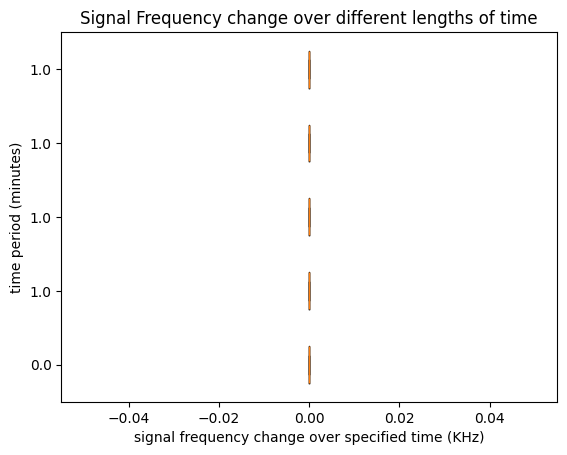

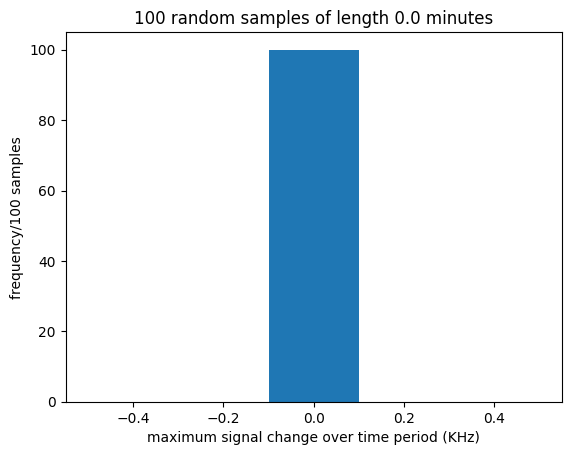

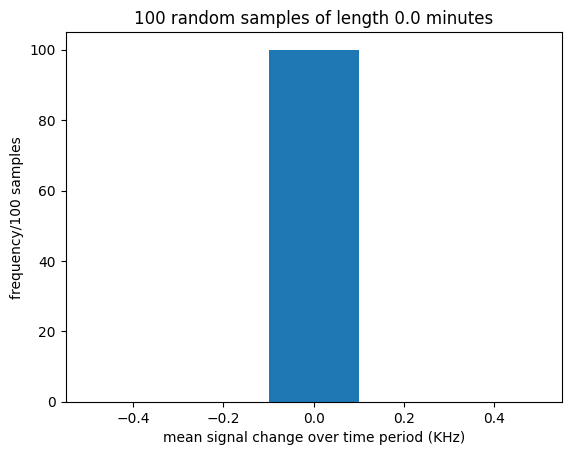

In [ ]:
# Now do the above a for different timescales and plot the delta variances as a boxplot

DC_modulation = 80e6 #(Hz)


timespan_min = 100
timespan_max = 1000

timespans = np.linspace(timespan_min, timespan_max, 5).astype(int)


boxplot_x = []
boxplot_y = []
for timespan in timespans:
    r = rd.randint(100, len(ts)-100)

    ts_sample = ts[r:r+timespan] 
    # can choose to plot any of these
    MHz_sample = np.array(peaks_MHz[r:r+timespan])
    vals_sample = peak_vals[r:r+timespan]
    nan_sample = nan_locs[r:r+timespan]
    delta_khz = (DC_modulation-MHz_sample)/1000
    sigchange = (MHz_sample-MHz_sample[0])/1000 # changes from Hz to KHz (plot this one)

    ts_sample_datetime = [pd.to_datetime(timestamp) for timestamp in ts_sample]
    timediff = str(round((ts_sample_datetime[-1] - ts_sample_datetime[0]).total_seconds() / 60,0))

    boxplot_y.append(timediff)
    boxplot_x.append(sigchange)


fig, ax = plt.subplots()

bp = ax.boxplot(boxplot_x, vert=0)

ax.set_yticklabels(boxplot_y)
ax.set_ylabel('time period (minutes)')
ax.set_xlabel('signal frequency change over specified time (KHz)')
plt.title('Signal Frequency change over different lengths of time')
plt.show()



# select one timescale and do a bunch of times, plot range as histogram

timespan = 100



histdata_range = []
histdata_mean = []
for i in range(100):
    r = rd.randint(100, len(ts)-100)

    ts_sample = ts[r:r+timespan] 
    MHz_sample = np.array(peaks_MHz[r:r+timespan])
    sigchange = (MHz_sample-MHz_sample[0])/1000 # changes from Hz to KHz
    MHzdif = np.nanmax(np.abs(sigchange)) # this time note the largest signal change in the data
    MHzmean = np.mean(np.abs(sigchange)) # and the mean signal change in the data - we will plot both as histograms

    histdata_range.append(MHzdif)
    histdata_mean.append(MHzmean)

ts_sample_datetime = [pd.to_datetime(timestamp) for timestamp in ts_sample]
timediff = str(round((ts_sample_datetime[-1] - ts_sample_datetime[0]).total_seconds() / 60,0))

plt.hist(histdata_range, bins=5)
plt.title('100 random samples of length {} minutes'.format(timediff))
plt.xlabel('maximum signal change over time period (KHz)')
plt.ylabel('frequency/100 samples')
plt.show()

plt.hist(histdata_mean, bins=5)
plt.title('100 random samples of length {} minutes'.format(timediff))
plt.xlabel('mean signal change over time period (KHz)')
plt.ylabel('frequency/100 samples')
plt.show()